<a href="https://colab.research.google.com/github/harukamasatsugu/Nikkei225options_pricing/blob/main/%E5%B9%BE%E4%BD%95%E3%83%96%E3%83%A9%E3%82%A6%E3%83%B3%E9%81%8B%E5%8B%95.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import files
uploaded = files.upload()

Saving nikkei_stock_average_daily_jp.csv to nikkei_stock_average_daily_jp.csv


In [ ]:
df = pd.read_csv("nikkei_stock_average_daily_jp.csv", encoding="cp932")
print(df.columns)
df.head()

Index(['データ日付', '終値', '始値', '高値', '安値'], dtype='object')


,データ日付,終値,始値,高値,安値
0,2022/01/04,29301.79,29098.41,29323.79,28954.56
1,2022/01/05,29332.16,29288.80,29388.16,29204.45
2,2022/01/06,28487.87,29136.75,29158.95,28487.87
3,2022/01/07,28478.56,28711.53,28813.09,28293.70
4,2022/01/11,28222.48,28380.90,28473.47,28089.49


期待成長率(/日): 0.00044, ボラティリティ(/日): 0.01223


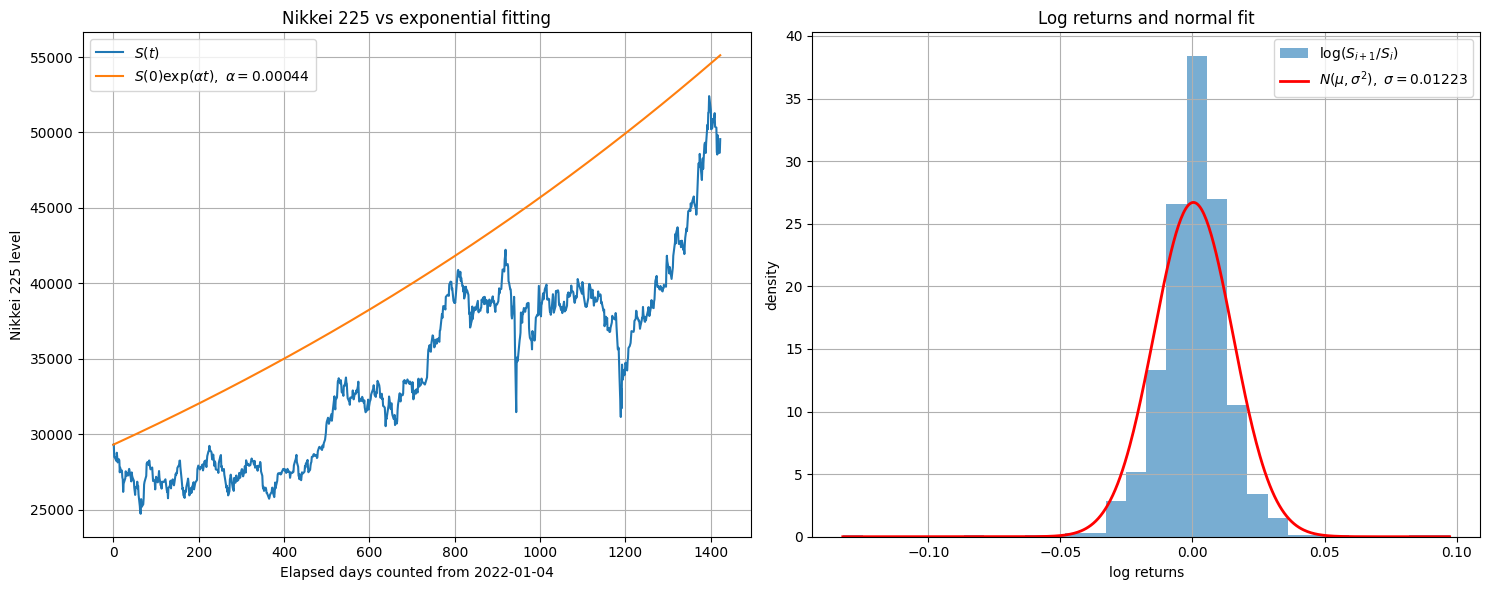

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import scipy.stats as stats

# 日経平均株価シートのロード
df = pd.read_csv("nikkei_stock_average_daily_jp.csv", encoding="cp932")

# 1) データ日付を一旦 Datetime に変換（注意書き行は NaT になる）
tmp_date = pd.to_datetime(df['データ日付'], format="%Y/%m/%d", errors="coerce")

# 2) 日付として解釈できる行だけ残す
df = df[tmp_date.notna()].copy()
df['Date'] = tmp_date[tmp_date.notna()]

# 3) 終値を数値として使う（列名は「終値」）
df['終値'] = pd.to_numeric(df['終値'], errors='coerce')
df = df.dropna(subset=['終値'])

# 経過日数
start_date = df['Date'].iloc[0]
df['ElapsedDays'] = (df['Date'] - start_date).dt.days

elapsed_days = df['ElapsedDays'].to_numpy()
end_values = df['終値'].to_numpy()

# 対数リターンを計算
log_returns = np.diff(np.log(end_values))
delta_t = np.diff(elapsed_days)  # 通常は全部 1 日
n = len(delta_t)

# パラメータの最尤推定（1日あたり）
mu_hat = np.sum(log_returns) / np.sum(delta_t)
sigma_hat = np.sqrt(np.sum((log_returns - mu_hat * delta_t)**2 / delta_t) / n)
alpha_hat = mu_hat + 0.5 * sigma_hat**2

print(f"期待成長率(/日): {alpha_hat:.5f}, ボラティリティ(/日): {sigma_hat:.5f}")

# プロット
fig = plt.figure(figsize=(15, 6))

# ax1: 日経平均株価と指数関数フィット
ax1 = fig.add_subplot(121)
ax1.plot(elapsed_days, end_values, label=r'$S(t)$')
ax1.plot(
    elapsed_days,
    end_values[0] * np.exp(alpha_hat * elapsed_days),
    label=rf'$S(0)\exp(\alpha t),\ \alpha={alpha_hat:.5f}$'
)
ax1.set_title("Nikkei 225 vs exponential fitting")
ax1.set_xlabel(f"Elapsed days counted from {start_date.date()}")
ax1.set_ylabel("Nikkei 225 level")
ax1.legend()
ax1.grid(True)

# ax2: log return ヒストグラムと正規分布フィット
ax2 = fig.add_subplot(122)
count, bins, ignored = ax2.hist(
    log_returns,
    bins=30,
    density=True,
    alpha=0.6,
    label=r'$\log(S_{i+1}/S_i)$'
)

x = np.linspace(min(log_returns), max(log_returns), 500)
# delta_t の平均を使って 1日リターンの分布を近似
pdf = stats.norm.pdf(x, loc=mu_hat, scale=sigma_hat * np.sqrt(delta_t.mean()))
ax2.plot(x, pdf, 'r-', lw=2, label=rf'$N(\mu,\sigma^2),\ \sigma={sigma_hat:.5f}$')

ax2.set_title("Log returns and normal fit")
ax2.set_xlabel("log returns")
ax2.set_ylabel("density")
ax2.legend()
ax2.grid(True)

plt.tight_layout()
plt.show()


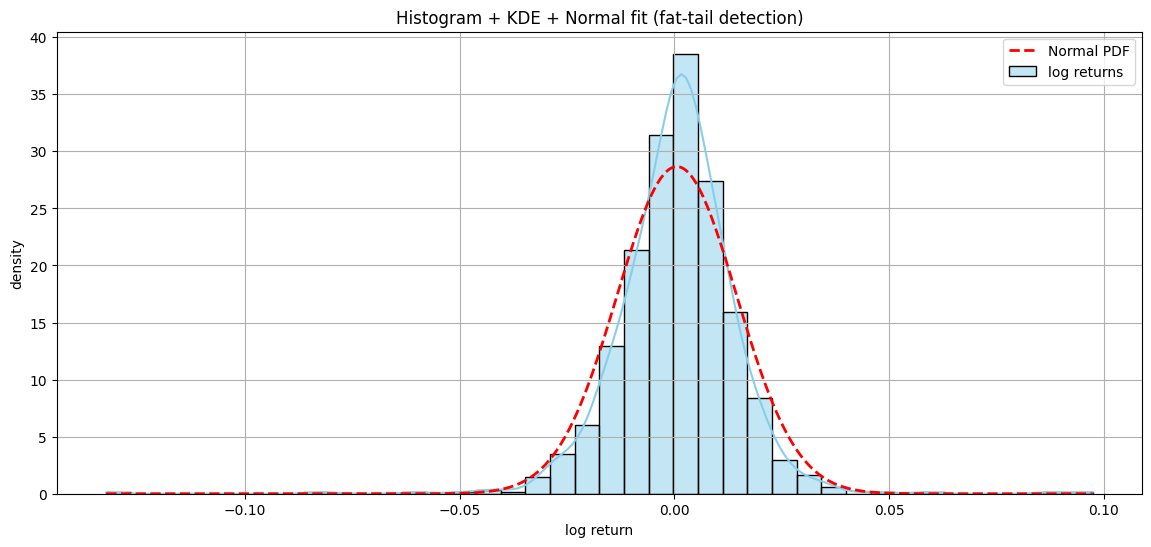

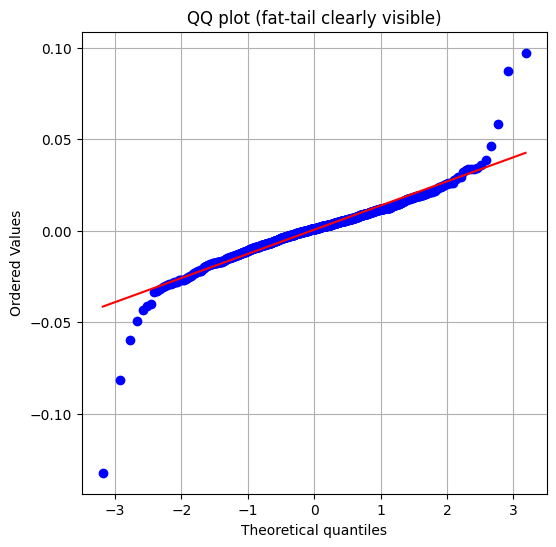

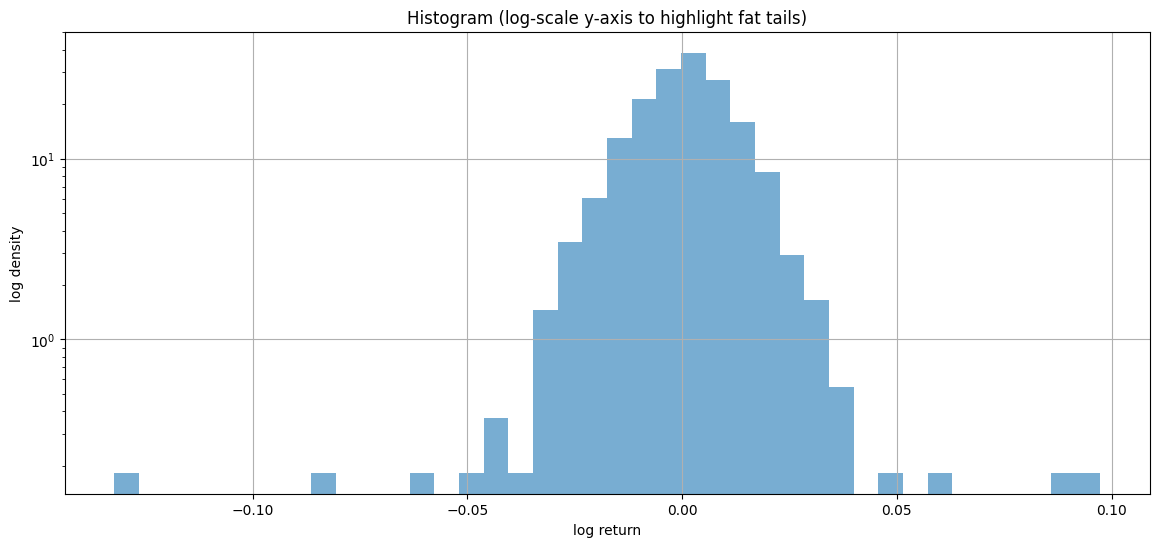

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import scipy.stats as stats
import seaborn as sns

# --- 前処理はそのまま使う（df, log_returns まで） ---

# ========== ① ヒストグラム + 正規分布 + KDE ==========
plt.figure(figsize=(14,6))
sns.histplot(log_returns, bins=40, kde=True, stat="density", color="skyblue", label="log returns")

x = np.linspace(min(log_returns), max(log_returns), 500)
pdf = stats.norm.pdf(x, loc=log_returns.mean(), scale=log_returns.std())
plt.plot(x, pdf, "r--", lw=2, label="Normal PDF")

plt.title("Histogram + KDE + Normal fit (fat-tail detection)")
plt.xlabel("log return")
plt.ylabel("density")
plt.legend()
plt.grid(True)
plt.show()

# ========== ② QQ プロット（正規分布とのズレを可視化） ==========
plt.figure(figsize=(6,6))
stats.probplot(log_returns, dist="norm", plot=plt)
plt.title("QQ plot (fat-tail clearly visible)")
plt.grid(True)
plt.show()

# ========== ③ 左右 tail を強調したログスケールプロット ==========
plt.figure(figsize=(14,6))
hist_vals, hist_bins, _ = plt.hist(log_returns, bins=40, density=True, alpha=0.6)

plt.yscale("log")  # ← これで tail がめちゃくちゃ強調される
plt.title("Histogram (log-scale y-axis to highlight fat tails)")
plt.xlabel("log return")
plt.ylabel("log density")
plt.grid(True)

plt.show()


バックテストをしたい。

In [ ]:
import numpy as np
import pandas as pd

# Parameters
mu = 0.00044
sigma = 0.01223
T = 500  # days to simulate
N = 1000  # number of simulation paths
S0 = 27000  # starting price (example: Nikkei spot)

# Simulate GBM paths
dt = 1
eps = np.random.normal(0, 1, (T, N))

S = np.zeros((T + 1, N))
S[0] = S0

for t in range(1, T + 1):
    S[t] = S[t-1] * np.exp((mu - 0.5 * sigma**2) * dt + sigma * np.sqrt(dt) * eps[t-1])

# Convert to DataFrame if needed
df_paths = pd.DataFrame(S)

In [ ]:
K = 0.9 * S0  # strike = 10% OTM
put_pnl = np.maximum(K - S[-1], 0)  # payoff
portfolio_pnl = S[-1] - S0  # unhedged pnl

hedged_pnl = portfolio_pnl + put_pnl

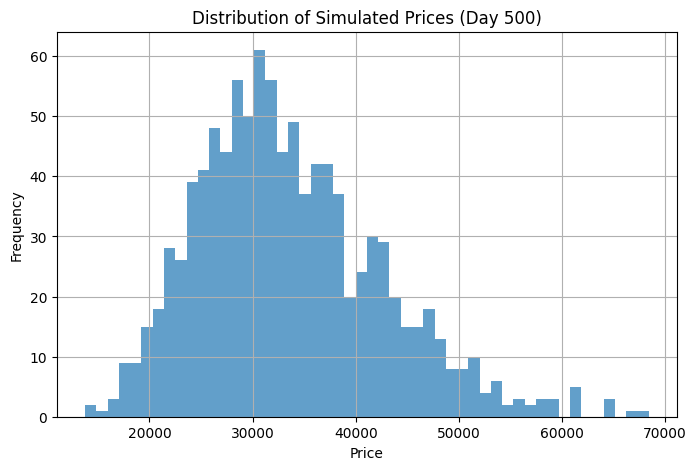

In [ ]:
plt.figure(figsize=(8,5))
plt.hist(S[-1], bins=50, alpha=0.7)
plt.title("Distribution of Simulated Prices (Day 500)")
plt.xlabel("Price")
plt.ylabel("Frequency")
plt.grid()
plt.show()

In [ ]:
sorted_prices = np.sort(S[-1])
returns = (sorted_prices - S0) / S0

VaR_1 = np.percentile(returns, 1)
VaR_5 = np.percentile(returns, 5)

print("1% VaR:", VaR_1)
print("5% VaR:", VaR_5)

1% VaR: -0.3432830779875457
5% VaR: -0.21733582690041686


In [ ]:
K = 0.9 * S0  # 10% OTM
put_payoff = np.maximum(K - S[-1], 0)
portfolio_pnl = S[-1] - S0
hedged_pnl = portfolio_pnl + put_payoff

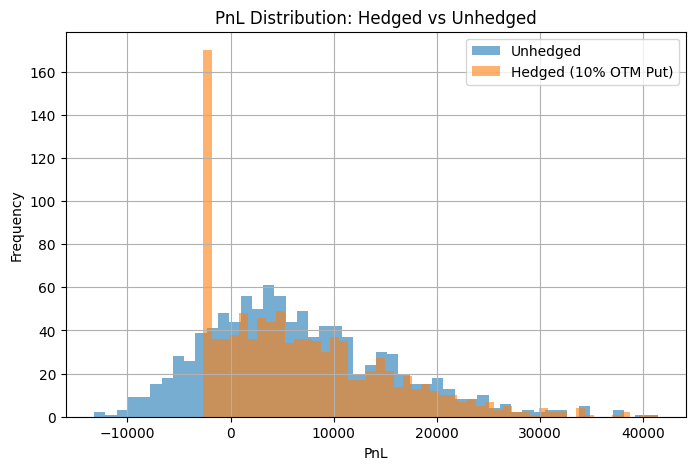

In [ ]:
plt.figure(figsize=(8,5))
plt.hist(portfolio_pnl, bins=50, alpha=0.6, label="Unhedged")
plt.hist(hedged_pnl, bins=50, alpha=0.6, label="Hedged (10% OTM Put)")
plt.title("PnL Distribution: Hedged vs Unhedged")
plt.xlabel("PnL")
plt.ylabel("Frequency")
plt.legend()
plt.grid()
plt.show()

/tmp/ipython-input-3301792085.py:2: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot([portfolio_pnl, hedged_pnl],


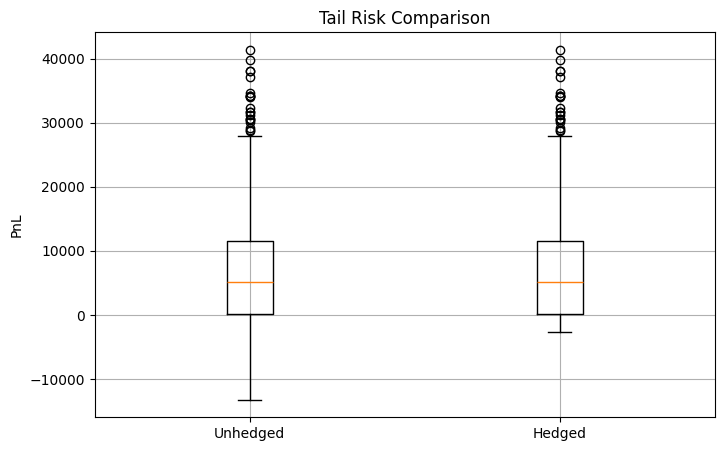

In [ ]:
plt.figure(figsize=(8,5))
plt.boxplot([portfolio_pnl, hedged_pnl],
            labels=["Unhedged", "Hedged"])
plt.title("Tail Risk Comparison")
plt.ylabel("PnL")
plt.grid()
plt.show()